Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Se ha creado un final muerto en el nodo 1: N
Se ha creado un final muerto en el nodo 2: C
Matriz de adyacencia
      A     B     C     D     E     F     G     H     I     J     K     L  \
A  0.01  0.29  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.29   
B  0.01  0.01  0.01  0.01  0.01  0.01  0.44  0.01  0.01  0.01  0.44  0.01   
C  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01   
D  0.01  0.01  0.01  0.01  0.01  0.44  0.01  0.01  0.01  0.01  0.44  0.01   
E  0

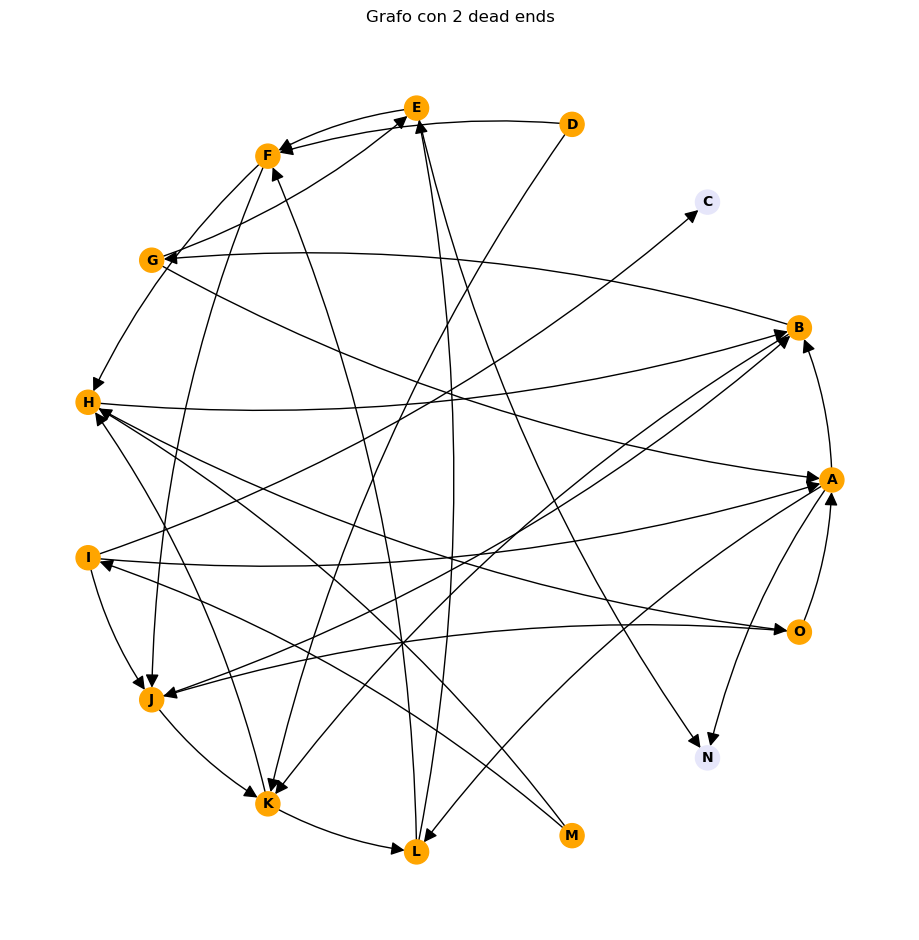

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd

dead_end_nodes = []  # Dead end nodes
graph_matrix = []
total_nodes = 15  # Total number of nodes

# Mapeo de números a letras
letter_map = {i+1: chr(65+i) for i in range(total_nodes)}  # {1: 'A', 2: 'B', ..., 15: 'O'}

# Crear una matriz de adyacencia estocástica
def adjacency_matrix(G):
    # Convertir a una matriz estocástica
    adjacency_matrix = nx.to_numpy_array(G, nodelist=list(G.nodes))  # Usamos las letras como nodos

    # Normalizar filas para que sumen 1
    normalized_matrix = np.array(adjacency_matrix, dtype=float)
    row_sums = normalized_matrix.sum(axis=1, keepdims=True)
    
    # Si la fila es cero (final muerto), permitir teletransportación uniforme
    row_sums[row_sums == 0] = 1.0  # Evitar divisiones por cero
    transition_matrix = normalized_matrix / row_sums
    
    # Agregar probabilidad de teletransportación
    teleport_prob = 0.15
    final_matrix = teleport_prob / total_nodes + (1 - teleport_prob) * transition_matrix
    return np.round(final_matrix, 2)

# Implementar el algoritmo de Power Iteration
def power_iteration_trace(transition_matrix, d=0.85, teleport_steps=None, verbose=False, max_iterations=100):
    # Inicializar el vector de rango
    N = transition_matrix.shape[0]
    rank_vector = np.ones(N) / N  # Vector inicial de distribución uniforme
    trace = [rank_vector.copy()]  # Guardar estado inicial

    tolerance = 1e-4  # Tolerancia de cambio
    delta = tolerance + 1 # Inicializar delta con un valor superior a la tolerancia
    iteration = 0

    # Iterar hasta que la diferencia sea menor que la tolerancia
    while delta > tolerance and iteration < max_iterations:
        iteration += 1

        # Aplicar fórmula PageRank con teletransportación
        new_rank_vector = d * np.dot(transition_matrix.T, rank_vector) + (1 - d) / N

        # Normalizar para que la suma sea 1
        new_rank_vector /= np.sum(new_rank_vector)

        # Comparar la diferencia entre el vector anterior y el nuevo
        delta = np.linalg.norm(new_rank_vector - rank_vector, 1)  # Norma L1

        # Imprimir el vector de rango y el cambio
        if verbose:
            rank_str = np.array2string(new_rank_vector, precision=4, separator=', ', suppress_small=True)
            print(f"Iteración {iteration}:\n {rank_str}\nCambio: {delta}")

        # Actualizar el vector de rango y guardar el estado
        rank_vector = new_rank_vector.copy()
        trace.append(rank_vector.copy())

    return trace  # Lista de vectores para cada iteración

# Simulación de caminante aleatorio
def walker_simulation(matrix):
    unvisited_nodes = set(nodes)
    current_position = random.choice(nodes)
    path_traveled = [current_position]
    print("El camino aleatorio empieza en:", current_position)
    counter = 0
    teleports = []
    iterations = 1  # Contador de iteraciones

    while unvisited_nodes:
        counter += 1

        # Verificar si el nodo actual es un dead end
        if current_position in dead_end_nodes:
            print(f"Has llegado a un dead end en el nodo: {current_position}")
            user_input = input("¿Quieres teletransportarte? (s/n): ").lower()
            # Teletransportarse a un nodo aleatorio
            if user_input == "s":
                current_position = random.choice([n for n in nodes if n in unvisited_nodes])
                print("Teletransportado a:", current_position)
                teleports.append(iterations)
            # Quedarse en el dead end
            else:
                print(f"Te has quedado en el dead end: {current_position}.")
        else:
            # Obtener probabilidades de transición para el nodo actual
            transition_probs = matrix.loc[current_position].values
            transition_probs /= transition_probs.sum()

            # Elegir el siguiente nodo basado en las probabilidades de transición
            user_input = input("¿Quieres teletransportarte? (s/n): ").lower()
            if user_input == "s":
                # Teletransportarse a un nodo aleatorio
                current_position = random.choice([n for n in nodes if n in unvisited_nodes])
                print("Teletransportado a:", current_position)
                teleports.append(iterations)
            else:
                # Elegir el siguiente nodo basado en las probabilidades de transición
                current_position = np.random.choice(nodes, p=transition_probs)

        # Iteraciones con Power Iteration
        power_iteration_trace(matrix, 0.85, teleports, True, iterations)

        # Incrementar el contador global
        iterations += 1

        # Añadir el nodo al camino recorrido
        path_traveled.append(current_position)
        print("Recorrido del random walker:", path_traveled)

        # Marcar el nodo como visitado
        if current_position in unvisited_nodes:
            unvisited_nodes.remove(current_position)

        # Verificar si todos los nodos han sido visitados
        if not unvisited_nodes:
            print("Se han visitado todos los nodos.")
            break

        # Preguntar si continuar
        user_input = input("¿Deseas continuar con el recorrido? (s/n): ").lower()
        if user_input != 's':
            break

    return path_traveled

# Agregar conexiones aleatorias
def add_random_connections(G, nodes):
    max_edges = 2  # Limitar a 2 conexiones por nodo para mantener simplicidad
    # Conectar nodos aleatorios
    for node in nodes:
        # Evitar agregar conexiones a dead ends
        if node not in dead_end_nodes:
            available_targets = [target for target in nodes if target != node]
            number_of_edges = min(max_edges, len(available_targets))  # Elegir un número limitado de conexiones
            # Elegir nodos aleatorios para conectar
            if number_of_edges > 0:
                selected_targets = random.sample(available_targets, number_of_edges)
                for target in selected_targets:
                    G.add_edge(node, target)
    return G

# Dibujar el grafo
def display_graph(G):
    # Crear un diccionario de colores para los nodos
    colors = ['lavender' if node in dead_end_nodes else 'orange' for node in G.nodes]
    
    plt.figure(figsize=(9, 9))
    positions = nx.circular_layout(G)
    
    # Las letras ya están etiquetadas como nodos
    labels = {node: node for node in G.nodes}
    
    nx.draw(G, positions, labels=labels, node_color=colors, font_size=10, font_color="black", font_weight="bold", arrowsize=20, connectionstyle="arc3,rad=0.1")
    plt.title("Grafo con 2 dead ends")

def generate_graph_with_nodes(node_count):
    G = nx.DiGraph()
    # Crear nodos con etiquetas de letras
    nodes = list(letter_map.values())  # Utilizamos las letras directamente como nodos
    for node in nodes:
        weight = random.uniform(0.1, 1.0)
        G.add_node(node, weight=weight)
    return G, nodes

def introduce_dead_ends(G, nodes):
    previous_node = None
    for i in range(2):  # Agregar 2 dead ends
        # Elegir un nodo aleatorio para conectar
        dead_end = random.choice([n for n in nodes if n not in dead_end_nodes and n != previous_node])
        dead_end_nodes.append(dead_end)
        # Elegir un nodo aleatorio para conectar el dead end
        connecting_node = random.choice([n for n in nodes if n not in dead_end_nodes and n != previous_node])

        # Conectar el nodo anterior al dead end
        G.add_edge(connecting_node, dead_end)  # Agregar arista hacia el dead end
        previous_node = connecting_node
        print(f"Se ha creado un final muerto en el nodo {i+1}: {dead_end}")

    return G

if __name__ == "__main__":
    # Inicializar el grafo
    G, nodes = generate_graph_with_nodes(total_nodes)
    G = introduce_dead_ends(G, nodes)
    G = add_random_connections(G, nodes)

    # Convertir la matriz de adyacencia en un DataFrame
    adj_matrix_df = pd.DataFrame(adjacency_matrix(G), index=nodes, columns=nodes)
    print("Matriz de adyacencia")
    print(adj_matrix_df)

    # Dibujar el grafo
    display_graph(G)

In [3]:
recorrido = walker_simulation(adj_matrix_df)
print("Recorrido del random walker: ", recorrido)

El camino aleatorio empieza en: O
Teletransportado a: F
Iteración 1:
 [0.0915, 0.0915, 0.0381, 0.0204, 0.074 , 0.1007, 0.0471, 0.1005, 0.0471,
 0.0915, 0.1005, 0.0648, 0.0204, 0.0648, 0.0471]
Cambio: 0.36695654377617515
Recorrido del random walker: ['O', 'F']
Teletransportado a: E
Iteración 1:
 [0.0915, 0.0915, 0.0381, 0.0204, 0.074 , 0.1007, 0.0471, 0.1005, 0.0471,
 0.0915, 0.1005, 0.0648, 0.0204, 0.0648, 0.0471]
Cambio: 0.36695654377617515
Iteración 2:
 [0.0689, 0.1187, 0.0321, 0.0199, 0.0639, 0.0824, 0.0557, 0.1065, 0.0279,
 0.0899, 0.0994, 0.0829, 0.0199, 0.0726, 0.0592]
Cambio: 0.15958281311879408
Recorrido del random walker: ['O', 'F', 'E']
Teletransportado a: A
Iteración 1:
 [0.0915, 0.0915, 0.0381, 0.0204, 0.074 , 0.1007, 0.0471, 0.1005, 0.0471,
 0.0915, 0.1005, 0.0648, 0.0204, 0.0648, 0.0471]
Cambio: 0.36695654377617515
Iteración 2:
 [0.0689, 0.1187, 0.0321, 0.0199, 0.0639, 0.0824, 0.0557, 0.1065, 0.0279,
 0.0899, 0.0994, 0.0829, 0.0199, 0.0726, 0.0592]
Cambio: 0.1595828131187

Spider Trap 1: M -> K -> O
Spider Trap 2: C -> A -> I
Matriz de adyacencia
      A     B     C     D     E     F     G     H     I     J     K     L  \
A  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.86  0.01  0.01  0.01   
B  0.01  0.01  0.44  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.44  0.01   
C  0.44  0.01  0.44  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01   
D  0.01  0.01  0.01  0.01  0.01  0.44  0.01  0.01  0.01  0.44  0.01  0.01   
E  0.44  0.01  0.01  0.01  0.01  0.44  0.01  0.01  0.01  0.01  0.01  0.01   
F  0.44  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01   
G  0.01  0.01  0.01  0.01  0.01  0.44  0.01  0.01  0.01  0.01  0.01  0.01   
H  0.01  0.01  0.44  0.44  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01   
I  0.01  0.01  0.86  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01   
J  0.01  0.01  0.44  0.44  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01   
K  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01   
L

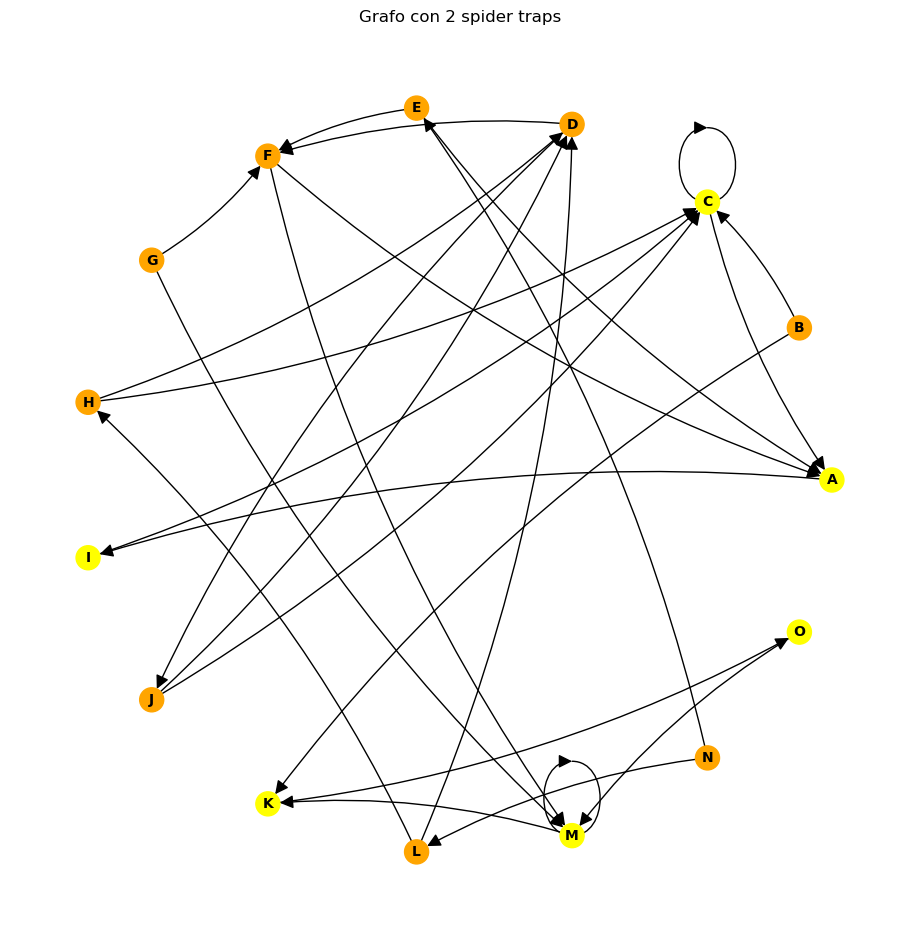

In [4]:
spider_trap_nodes = []  # Spider Trap nodes

def walker_simulation_for_spiders(matrix):
    unvisited_nodes = set(nodes)
    current_position = random.choice(nodes)
    path_traveled = [current_position]
    print("El recorrido aleatorio empieza en:", current_position)
    counter = 0
    teleports = []
    iterations = 1  # Contador de iteraciones

    while unvisited_nodes:
        counter += 1

        if current_position in spider_trap_nodes:
            print(f"Has llegado a un spider trap en el nodo: {current_position}")
            user_input = input("¿Quieres teletransportarte? (s/n): ").lower()
            if user_input == "s":
                current_position = random.choice([n for n in nodes if n in unvisited_nodes])
                print("Teletransportado a:", current_position)
                teleports.append(iterations)
            else:
                print("Te has quedado en el spider trap:", current_position)
        else:
            # Obtener probabilidades de transición para el nodo actual
            transition_probs = matrix.loc[current_position].values
            transition_probs /= transition_probs.sum()

            user_input = input("¿Quieres Teletransportarte? (s/n): ").lower()
            if user_input == "s":
                current_position = random.choice([n for n in nodes if n in unvisited_nodes])
                print("Teletransportado a:", current_position)
                teleports.append(iterations)
            else:
                current_position = np.random.choice(nodes, p=transition_probs)

        # Iteraciones con Power Iteration
        power_iteration_trace(matrix, 0.85, teleports, True, iterations)

        # Incrementar el contador global
        iterations += 1

        # Añadir el nodo al camino recorrido
        path_traveled.append(current_position)
        print("Ruta del caminante aleatorio:", path_traveled)

        # Marcar el nodo como visitado
        if current_position in unvisited_nodes:
            unvisited_nodes.remove(current_position)

        # Verificar si todos los nodos han sido visitados
        if not unvisited_nodes:
            print("Se han visitado todos los nodos.")
            break

        # Preguntar si continuar
        user_input = input("¿Deseas continuar con el recorrido? (s/n): ").lower()
        if user_input != 's':
            break

    return path_traveled

def introduce_spider_traps(G, nodes):
    for i in range(2):  # Crear 3 Spider Traps
        # Elegir un nodo aleatorio para conectar
        spider_trap = random.choice([n for n in nodes if n not in spider_trap_nodes])
        spider_trap_nodes.append(spider_trap)
        # Elegir un nodo aleatorio para conectar el Spider Trap
        next_node = random.choice([n for n in nodes if n not in spider_trap_nodes])
        spider_trap_nodes.append(next_node)
        # Elegir un nodo aleatorio para conectar el siguiente nodo
        next_node2 = random.choice([n for n in nodes if n not in spider_trap_nodes])
        spider_trap_nodes.append(next_node2)

        G.add_edge(spider_trap, spider_trap)  # Conexión consigo mismo
        G.add_edge(spider_trap, next_node) # Conectar el Spider Trap al siguiente nodo
        G.add_edge(next_node, next_node2) # Conectar el siguiente nodo al siguiente nodo 2
        G.add_edge(next_node2, spider_trap) # Conectar el siguiente nodo 2 al Spider Trap

        print(f"Spider Trap {i + 1}: {spider_trap} -> {next_node} -> {next_node2}")

    return G

def add_random_connections_for_spiders(G, nodes):
    max_edges = 2  # Limitar a 2 conexiones por nodo para mantener simplicidad
    for node in nodes:
        if node not in spider_trap_nodes:
            available_targets = [target for target in nodes if target != node]
            number_of_edges = min(max_edges, len(available_targets))  # Elegir un número limitado de conexiones
            if number_of_edges > 0:
                selected_targets = random.sample(available_targets, number_of_edges)
                for target in selected_targets:
                    G.add_edge(node, target)
    return G

def display_graph_for_spiders(G):
    # Crear un diccionario de colores para los nodos
    colors = ['yellow' if node in spider_trap_nodes else 'orange' for node in G.nodes]
    
    plt.figure(figsize=(9, 9))
    positions = nx.circular_layout(G)
    
    # Las letras ya están etiquetadas como nodos
    labels = {node: node for node in G.nodes}
    
    nx.draw(G, positions, labels=labels, node_color=colors, font_size=10, font_color="black", font_weight="bold", arrowsize=20, connectionstyle="arc3,rad=0.1")
    plt.title("Grafo con 2 spider traps")

if __name__ == "__main__":
    # Inicializar el grafo
    G, nodes = generate_graph_with_nodes(total_nodes)
    G = introduce_spider_traps(G, nodes)
    G = add_random_connections_for_spiders(G, nodes)

    # Convertir la matriz de adyacencia en un DataFrame
    adj_matrix_df = pd.DataFrame(adjacency_matrix(G), index=nodes, columns=nodes)
    print("Matriz de adyacencia")
    print(adj_matrix_df)

    # Dibujar el grafo
    display_graph_for_spiders(G)

In [6]:
recorrido_2 = walker_simulation_for_spiders(adj_matrix_df)
print("Recorrido del Random Walker: ", recorrido_2)

El recorrido aleatorio empieza en: N
Teletransportado a: G
Iteración 1:
 [0.0912, 0.0184, 0.163 , 0.0905, 0.0424, 0.0912, 0.0184, 0.0424, 0.0664,
 0.0427, 0.0669, 0.0424, 0.1392, 0.0184, 0.0664]
Cambio: 0.48409125649774043
Ruta del caminante aleatorio: ['N', 'G']
Teletransportado a: I
Iteración 1:
 [0.0913, 0.0184, 0.1631, 0.0905, 0.0425, 0.091 , 0.0184, 0.0425, 0.0664,
 0.0427, 0.067 , 0.0425, 0.139 , 0.0184, 0.0664]
Cambio: 0.4837875974163094
Iteración 2:
 [0.1263, 0.0184, 0.1629, 0.0644, 0.025 , 0.0734, 0.0184, 0.0337, 0.084 ,
 0.0513, 0.0757, 0.025 , 0.1565, 0.0184, 0.0666]
Cambio: 0.17523214687063676
Ruta del caminante aleatorio: ['N', 'G', 'I']
Has llegado a un spider trap en el nodo: I
Teletransportado a: B
Iteración 1:
 [0.0913, 0.0184, 0.1631, 0.0905, 0.0425, 0.091 , 0.0184, 0.0425, 0.0664,
 0.0427, 0.067 , 0.0425, 0.139 , 0.0184, 0.0664]
Cambio: 0.4837875974163094
Iteración 2:
 [0.1263, 0.0184, 0.1629, 0.0644, 0.025 , 0.0734, 0.0184, 0.0337, 0.084 ,
 0.0513, 0.0757, 0.025 , 0